In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Load the CSV files
malnutrition = pd.read_csv("unicef_malnutrition.csv")
gdp = pd.read_csv("worldbank_gdp.csv")
food_prices = pd.read_csv("fao_food_prices.csv")

# Clean malnutrition dataset
malnutrition = malnutrition.loc[:, ~malnutrition.columns.str.contains('^Unnamed')]
malnutrition.columns = malnutrition.columns.str.strip()
malnutrition.dropna(inplace=True)

# Clean GDP dataset
gdp = gdp.loc[:, ~gdp.columns.str.contains('^Unnamed')]
gdp.columns = gdp.columns.str.strip()

# Clean food prices dataset
food_prices = food_prices.loc[:, ~food_prices.columns.str.contains('^Unnamed')]
food_prices.columns = food_prices.columns.str.strip()


In [9]:
# Drop rows with missing data for now
malnutrition.dropna(inplace=True)

In [10]:
# View first few rows
malnutrition.head()

,Indicator,Measure,ISO Code,Country or Area,Year,Both Sexes - Point Estimates,Both Sexes - Lower Limit,Both Sexes - Upper Limit,Male - Point Estimate,Male - Lower Limit,Male - Upper Limit,Female - Point Estimate,Female - Lower Limit,Female - Upper Limit,Note
2825,Overweight,Prevalence,MUS,Mauritius,2000,7.2,4.2,12.3,7.7,4.4,13.1,6.7,3.9,11.4,1.0
2826,Overweight,Prevalence,MUS,Mauritius,2001,7.4,4.1,12.9,7.8,4.5,13.5,6.9,3.8,12.2,1.0
2827,Overweight,Prevalence,MUS,Mauritius,2002,7.5,4.0,13.6,7.9,4.2,14.5,6.9,3.7,12.6,1.0
2828,Overweight,Prevalence,MUS,Mauritius,2003,7.5,3.9,14.0,8.0,4.1,14.9,7.0,3.7,13.0,1.0
2829,Overweight,Prevalence,MUS,Mauritius,2004,7.5,3.7,14.6,8.0,4.0,15.3,7.0,3.4,13.8,1.0


In [21]:
#cleaning the columns for merge
with open("fao_food_prices.csv", "r", encoding="utf-8", errors="ignore") as f:
    for _ in range(5):
        print(f.readline())


food_prices = pd.read_csv("fao_food_prices.csv", skiprows=2)  # adjust the number as needed
food_prices["Year"] = pd.to_datetime(food_prices["Date"]).dt.year
food_prices = food_prices.drop(columns=["Date"])


FAO Food Price Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

2014-2016=100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Date,Food Price Index,Meat,Dairy,Cereals,Oils,Sugar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

1990-01,64.4,74.3,53.5,64.1,44.59,87.9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,



In [107]:
#Merging data sets
# Step 1: Rename country column to match
gdp.rename(columns={"Country Name": "Country"}, inplace=True)

# Step 2: Extract proper year strings from column names like '2000[YR2000]'
cleaned_columns = {}
for col in gdp.columns:
    if "[YR" in col:
        # Extract the actual year part before the bracket
        year = col.split("[")[0]
        cleaned_columns[col] = year

# Step 3: Rename those columns
gdp.rename(columns=cleaned_columns, inplace=True)

# Step 4: Now get only numeric year columns
year_columns = [col for col in gdp.columns if col.isdigit()]

# Step 5: Melt the data
gdp_long = gdp.melt(id_vars=["Country"], value_vars=year_columns,
                    var_name="Year", value_name="GDP")

# Step 6: Convert Year column to integer
gdp_long["Year"] = gdp_long["Year"].astype(int)

# Merge with your existing main df
df = pd.merge(df, econ_pivot, on=["Country", "Year"], how="inner")



In [108]:
# Melt the year columns (e.g., '2000 [YR2000]', '2001 [YR2001]', ...) into a 'Year' column
gdp_melted = gdp.melt(
    id_vars=["Country", "Country Code", "Series Name"],
    var_name="Year",
    value_name="Value"
)

# Clean the year column (extract 4-digit year)
gdp_melted["Year"] = gdp_melted["Year"].str.extract(r"(\d{4})")
gdp_melted.dropna(subset=["Year"], inplace=True)
gdp_melted["Year"] = gdp_melted["Year"].astype(int)


In [109]:
# Pivot so each 'Series Name' becomes a separate column (e.g., GDP, Inflation)
gdp_melted["Value"] = pd.to_numeric(gdp_melted["Value"], errors="coerce")

econ_pivot = gdp_melted.pivot_table(
    index=["Country", "Year"],
    columns="Series Name",
    values="Value"
).reset_index()

# Optional: Rename for simplicity
econ_pivot.columns.name = None
econ_pivot.rename(columns={
    "Country Name": "Country",
    "GDP per capita (current US$)": "GDP",
    "Inflation, consumer prices (annual %)": "Inflation"
}, inplace=True)


In [110]:
#Debugging
print("Years in malnutrition:", malnutrition["Year"].unique())
print("Years in gdp_long:", gdp_long["Year"].unique())
print("Years in food_prices:", food_prices["Year"].unique())


Years in malnutrition: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]
Years in gdp_long: []
Years in food_prices: [  nan 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000.
 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012.
 2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021. 2022. 2023. 2024.
 2025.]


In [111]:
# Step 1: Reshape from wide to long format
gdp_long = gdp.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="GDP"
)

# Step 2: Extract numeric year from column like "2000 [YR2000]"
gdp_long["Year"] = gdp_long["Year"].str.extract(r"(\d{4})")
gdp_long = gdp_long.dropna(subset=["Year"])
gdp_long["Year"] = gdp_long["Year"].astype(int)

# Step 3: Rename "Country Name" to "Country" to match other DataFrames
gdp_long.rename(columns={"Country Name": "Country"}, inplace=True)

# Step 4 (Optional): Clean country names
gdp_long["Country"] = gdp_long["Country"].str.strip()


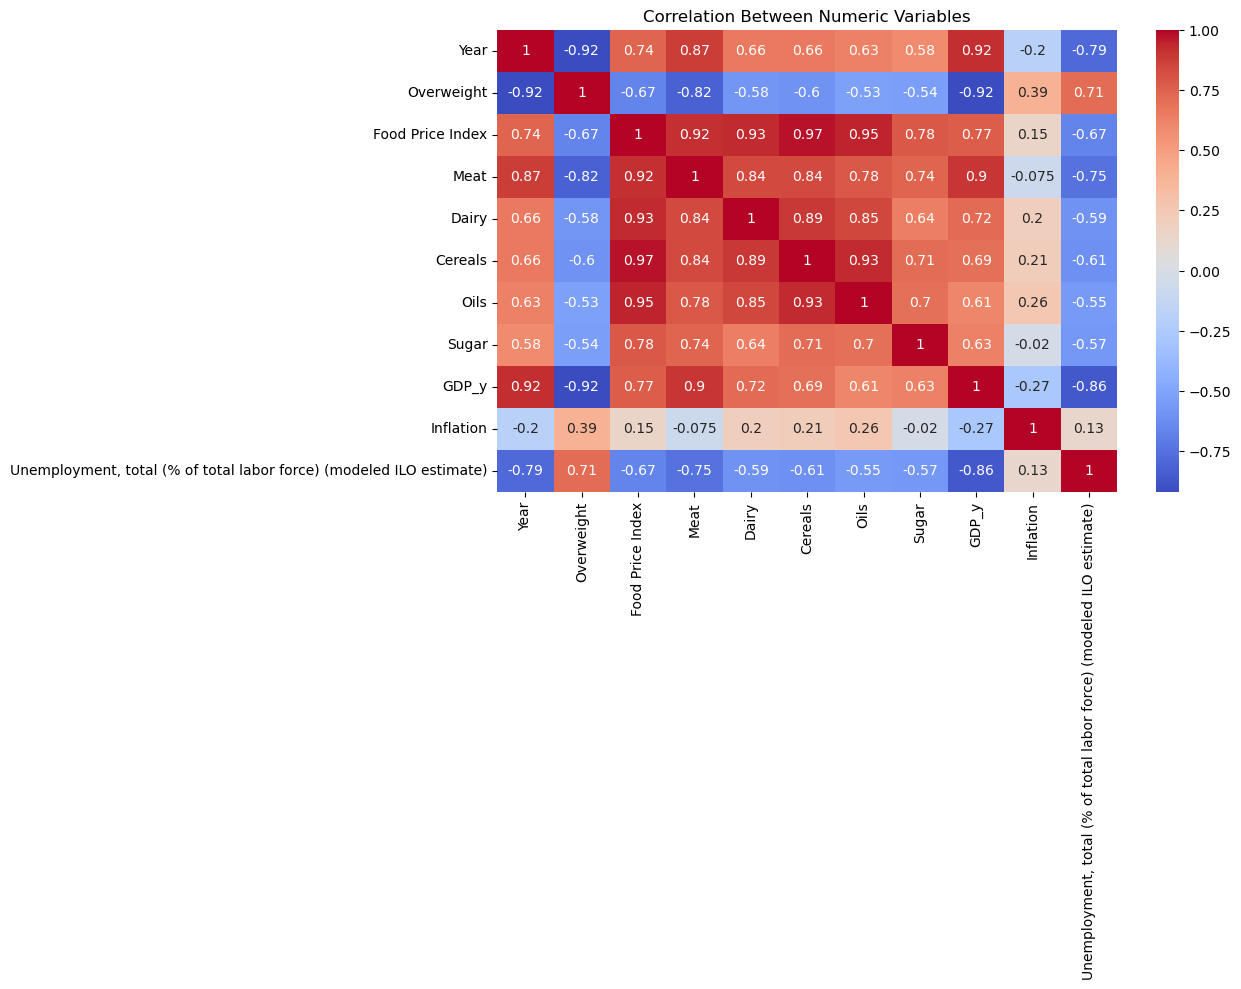

In [112]:
# Correlation heatmap (only numeric columns)
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=['number'])  # only keep numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Variables")
plt.show()


In [113]:
# Drop all columns that start with "Unnamed"
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [114]:
print(df.columns.tolist())


['Country', 'Year', 'Overweight', 'GDP_x', 'Food Price Index', 'Meat', 'Dairy', 'Cereals', 'Oils', 'Sugar', 'GDP_y', 'Inflation', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']


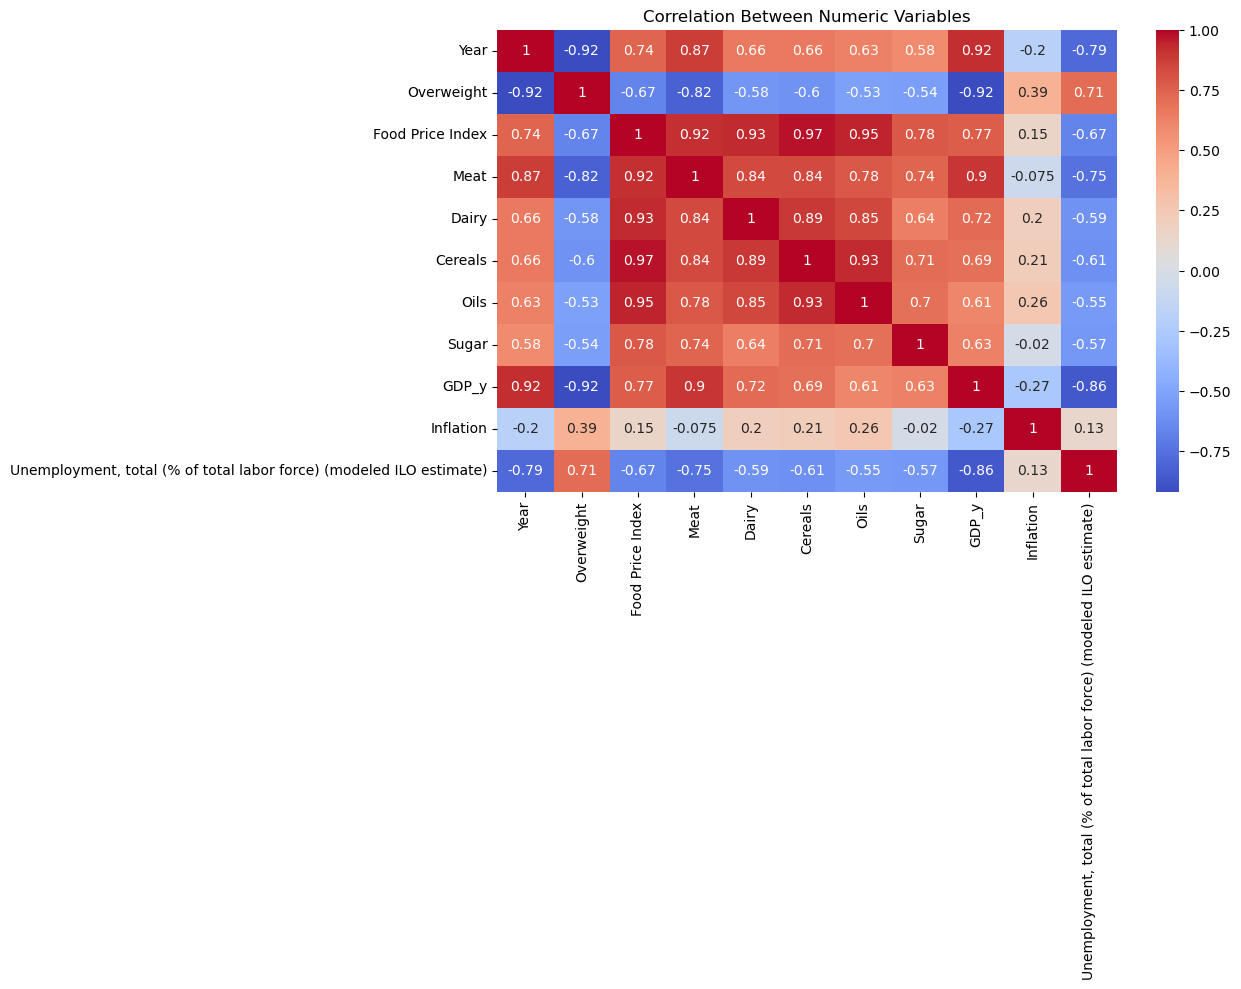

In [115]:
# Correlation heatmap with clean data
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=['number'])  # Only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Variables")
plt.show()


In [130]:
print(malnutrition.columns)


Index(['Indicator', 'Measure', 'ISO Code', 'Country', 'Year',
       'Both Sexes - Point Estimates', 'Both Sexes - Lower Limit',
       'Both Sexes - Upper Limit', 'Male - Point Estimate',
       'Male - Lower Limit', 'Male - Upper Limit', 'Female - Point Estimate',
       'Female - Lower Limit', 'Female - Upper Limit', 'Note'],
      dtype='object')


In [117]:
# Convert the column to numeric (force coercion, non-convertible values become NaN)
malnutrition["Both Sexes - Point Estimates"] = pd.to_numeric(
    malnutrition["Both Sexes - Point Estimates"], errors="coerce"
)
# Pivot malnutrition data so that each Indicator becomes a separate column
malnutrition_pivot = malnutrition.pivot_table(
    index=["Country", "Year"],
    columns="Indicator",
    values="Both Sexes - Point Estimates"
).reset_index()


In [118]:
# Merge GDP with malnutrition
df = pd.merge(malnutrition_pivot, gdp_long, on=["Country", "Year"], how="inner")

# Merge food prices on 'Year' only (if global)
df = pd.merge(df, food_prices, on="Year", how="left")


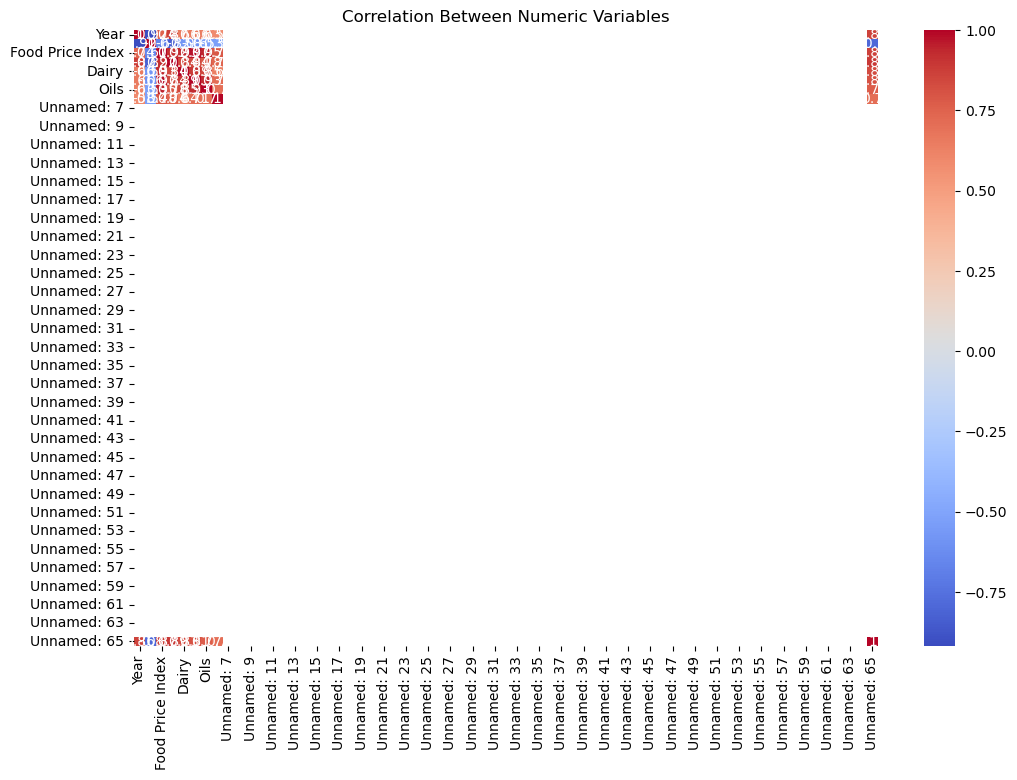

In [119]:
# Correlation heatmap with only numeric columns
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Variables")
plt.show()


In [120]:
# Remove unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Optional: drop any columns you don't want in correlation (like Note, ISO Code, etc.)
df = df.drop(columns=[col for col in df.columns if col.lower() in ['note', 'iso code']], errors='ignore')


In [121]:
# Now extract numeric columns only
numeric_df = df.select_dtypes(include=['number'])

# Check which numeric columns will be plotted
print("Numeric columns:", numeric_df.columns.tolist())


Numeric columns: ['Year', 'Overweight', 'Food Price Index', 'Meat', 'Dairy', 'Cereals', 'Oils', 'Sugar']


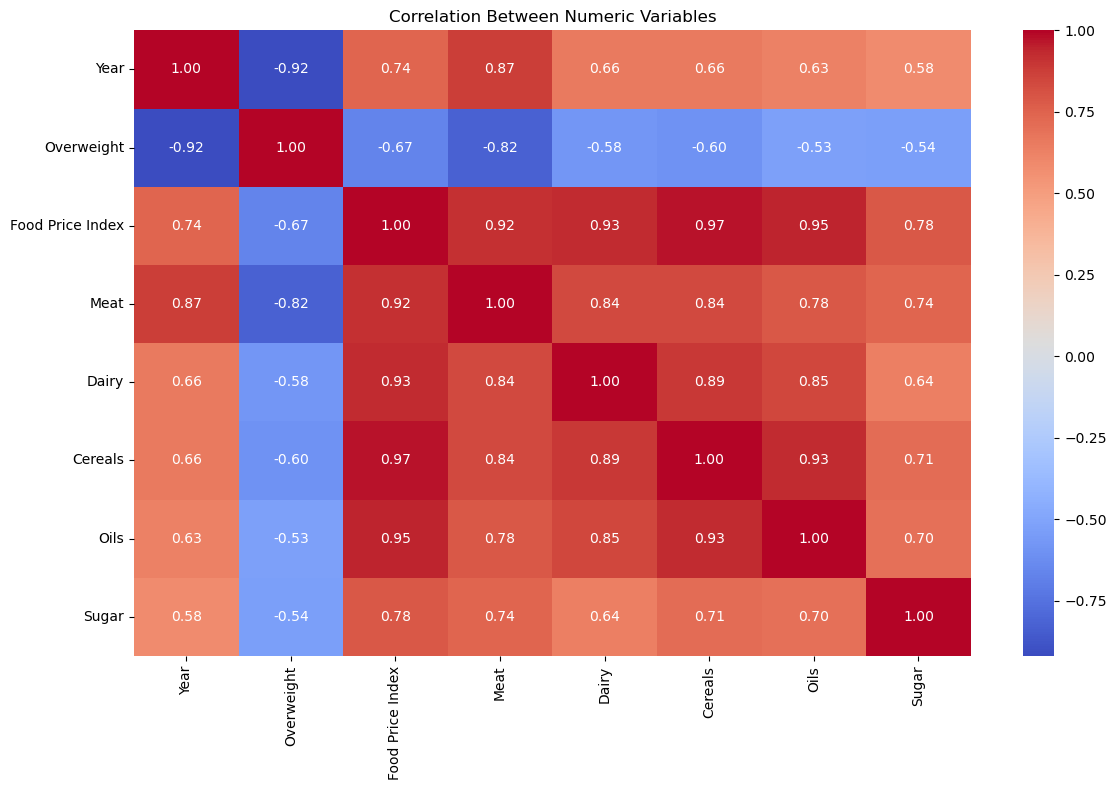

In [122]:
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Variables")
plt.tight_layout()
plt.show()


In [140]:
# Keep only the necessary numeric columns
selected_columns = ['Year', 'Overweight', 'Food Price Index']
filtered_df = df[selected_columns].copy()


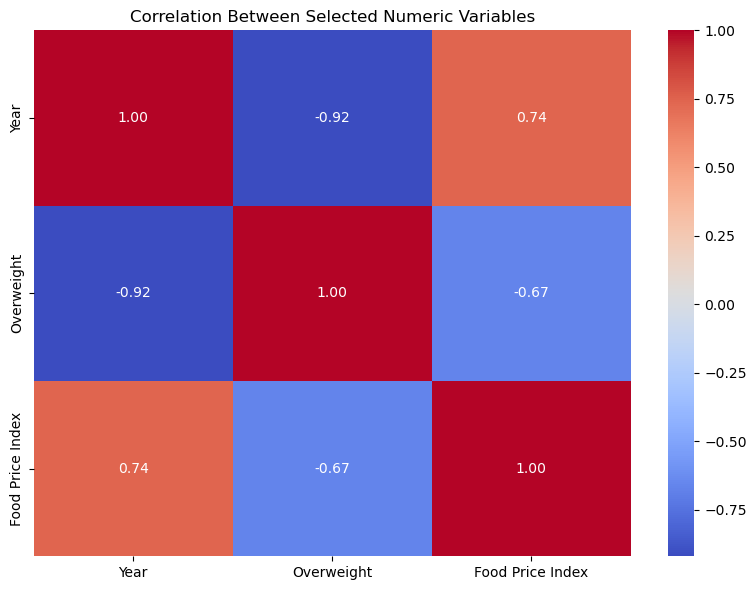

In [141]:
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Selected Numeric Variables")
plt.tight_layout()
plt.show()


In [142]:
# Filter the DataFrame for relevant columns
df_filtered = df[['Country', 'Year', 'Overweight', 'Food Price Index']]

# Display first few rows
df_filtered.head()


,Country,Year,Overweight,Food Price Index
0,Mauritius,2000,7.2,52.8
1,Mauritius,2000,7.2,52.5
2,Mauritius,2000,7.2,53.1
3,Mauritius,2000,7.2,53.7
4,Mauritius,2000,7.2,54.0


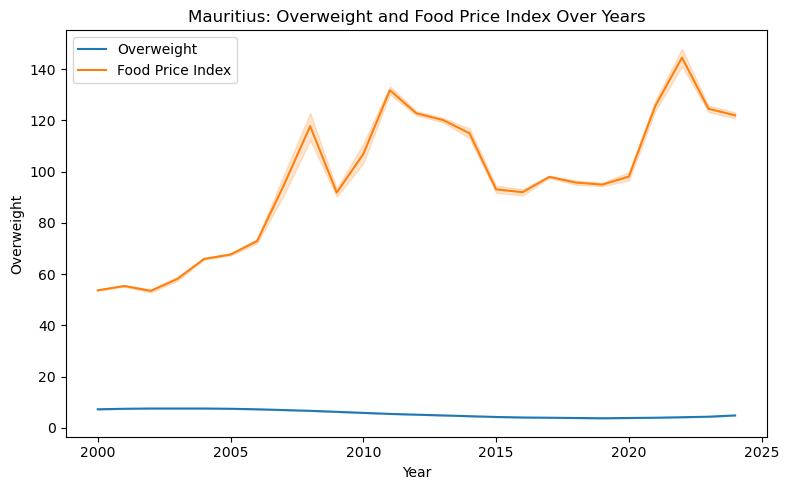

In [143]:
# Filter data for a specific country
country_df = df[df['Country'] == 'Mauritius']

# Plot Overweight vs Food Price Index
plt.figure(figsize=(8,5))
sns.lineplot(data=country_df, x='Year', y='Overweight', label='Overweight')
sns.lineplot(data=country_df, x='Year', y='Food Price Index', label='Food Price Index')
plt.title("Mauritius: Overweight and Food Price Index Over Years")
plt.legend()
plt.tight_layout()
plt.show()


In [144]:
#explore the data (EDA)

#Step 5.1: Basic Statistics and Missing Values
# Overview of numeric statistics
df.describe()

# Count missing values in each column
df.isnull().sum()


Country             0
Year                0
Overweight          0
GDP_x               0
Food Price Index    0
Meat                0
Dairy               0
Cereals             0
Oils                0
Sugar               0
GDP_y               0
Inflation           0
Unemployment        0
dtype: int64

In [145]:
print(df.columns.tolist())


['Country', 'Year', 'Overweight', 'GDP_x', 'Food Price Index', 'Meat', 'Dairy', 'Cereals', 'Oils', 'Sugar', 'GDP_y', 'Inflation', 'Unemployment']


In [146]:
gdp = pd.read_csv("worldbank_gdp.csv")
print(gdp.columns.tolist())
gdp.head()


['Country Name', 'Country Code', 'Series Name', 'Series Code', '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]', '2024 [YR2024]']


,Country Name,Country Code,Series Name,Series Code,2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,174.930991430166,138.706821676113,178.954088379235,198.871115728727,221.763653873013,254.184249149336,...,565.569730408751,522.082215583898,525.469770891619,491.337221382603,496.6025042585,510.787063366811,356.496214115892,357.261152798144,413.757894705303,..
1,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,..,..,..,..,..,12.6862687216715,...,-0.661709164713742,4.38389195513915,4.97595150553833,0.626149149168847,2.30237251516834,5.60188791482224,5.13320340824963,13.7121023720065,-4.64470870797775,-6.60118564073726
2,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,7.935,7.953,7.93,7.88,7.899,7.885,...,9.052,10.133,11.184,11.196,11.185,11.71,11.994,14.1,13.991,13.295
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,1160.42047054038,1326.41652388077,1479.83884572006,1908.69900687608,2446.90949947798,2741.72136549578,...,3981.72662261867,4168.37544462548,4614.0479692596,5365.48880180298,5460.4305086932,5370.77749956875,6413.28280828537,6846.42669381643,8575.17134637222,10011.6279856667
4,Albania,ALB,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,0.0500181363468309,3.10758827031434,7.77052583431552,0.48400261181847,2.28001916938101,2.36658195679796,...,1.89617402592365,1.2754316836741,1.98666133171199,2.02805963071136,1.41109078954246,1.62088661717011,2.04147163139549,6.72520271530048,4.75976421930107,2.21448953273292


In [147]:
# Step 1: Melt year columns into a single 'Year' column
gdp_melted = gdp.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    var_name="Year",
    value_name="Value"
)

# Step 2: Clean Year column to just the 4-digit year
gdp_melted["Year"] = gdp_melted["Year"].str.extract(r"(\d{4})").astype(int)

# Step 3: Drop rows with missing values
gdp_melted.dropna(subset=["Value"], inplace=True)

# Step 4: Convert 'Value' column to numeric (sometimes it's string!)
gdp_melted["Value"] = pd.to_numeric(gdp_melted["Value"], errors="coerce")


In [148]:
# Pivot: each 'Series Name' (e.g., Inflation) becomes a column
econ_pivot = gdp_melted.pivot_table(
    index=["Country Name", "Year"],
    columns="Series Name",
    values="Value"
).reset_index()

# Remove the columns index name
econ_pivot.columns.name = None


In [149]:
# Rename to simpler column names
econ_pivot.rename(columns={
    "Country Name": "Country",
    "GDP per capita (current US$)": "GDP",
    "Inflation, consumer prices (annual %)": "Inflation",
    "Unemployment, total (% of total labor force) (modeled ILO estimate)": "Unemployment"
}, inplace=True)


In [150]:
df = pd.merge(df, econ_pivot, on=["Country", "Year"], how="left")


In [170]:
print(df.columns.tolist())


['Country', 'Year', 'Overweight', 'GDP_x', 'Food Price Index', 'Meat', 'Dairy', 'Cereals', 'Oils', 'Sugar', 'GDP_y', 'Inflation', 'Unemployment', 'GDP_y', 'Inflation_y', 'Unemployment_y']


In [171]:
print(df[['GDP_x', 'GDP_y']].head())
print(df[['Inflation', 'Inflation_y']].head())
print(df[['Unemployment', 'Unemployment_y']].head())


              GDP_x        GDP_y        GDP_y
0  3981.98343249582  3981.983432  3981.983432
1  3981.98343249582  3981.983432  3981.983432
2  3981.98343249582  3981.983432  3981.983432
3  3981.98343249582  3981.983432  3981.983432
4  3981.98343249582  3981.983432  3981.983432
   Inflation  Inflation_y
0   4.199288     4.199288
1   4.199288     4.199288
2   4.199288     4.199288
3   4.199288     4.199288
4   4.199288     4.199288
   Unemployment  Unemployment_y
0         9.138           9.138
1         9.138           9.138
2         9.138           9.138
3         9.138           9.138
4         9.138           9.138


In [172]:
df.rename(columns={
    'GDP_x': 'GDP',
    'Inflation_x': 'Inflation',
    'Unemployment_x': 'Unemployment'
}, inplace=True)


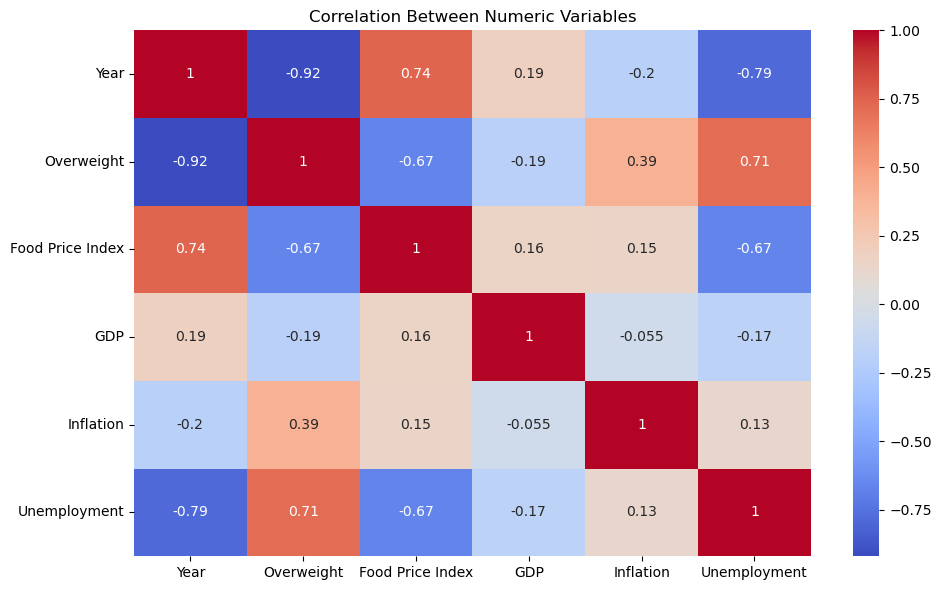

In [184]:
#Step 5.2 Correlation Heatmap
selected_cols = ['Year', 'Overweight', 'Food Price Index', 'GDP', 'Inflation', 'Unemployment']
numeric_df = df[selected_cols].dropna()

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numeric Variables")
plt.tight_layout()
plt.show()



In [174]:
#Step 6.1: Select Features and Target Variable
# Features (independent variables)
X = df[['GDP', 'Inflation', 'Food Price Index','Inflation','Unemployment']]

# Target (dependent variable)
y = df['Overweight']  # or any other pivoted malnutrition indicator


In [175]:
#Step 6.2: Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.dropna(), y.dropna(), test_size=0.2, random_state=42
)


In [176]:
#Step 7.1: Train a Random Forest Regression Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate model performance
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Root Mean Squared Error (RMSE): 0.0796843425300379
R² Score: 0.9969078783796032


In [177]:
#8.1: Feature Importance
importances = model.feature_importances_
features = X.columns

for feat, imp in zip(features, importances):
    print(f"{feat}: {imp:.4f}")


GDP: 0.0001
Inflation: 0.0617
Food Price Index: 0.6982
Inflation: 0.0597
Unemployment: 0.1803


In [178]:
#Step 8.2: SHAP for Explainability
!pip install shap


In [179]:
# Ensure X_train and X_test are strictly numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Optionally drop any rows with NaNs introduced during conversion
X_train = X_train.dropna()
X_test = X_test.dropna()


In [185]:
print(X_train.columns.tolist())


['GDP', 'Inflation', 'Food Price Index', 'Inflation', 'Unemployment']


In [186]:
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


In [187]:
print(X_train.columns.tolist())


['GDP', 'Inflation', 'Food Price Index', 'Unemployment']


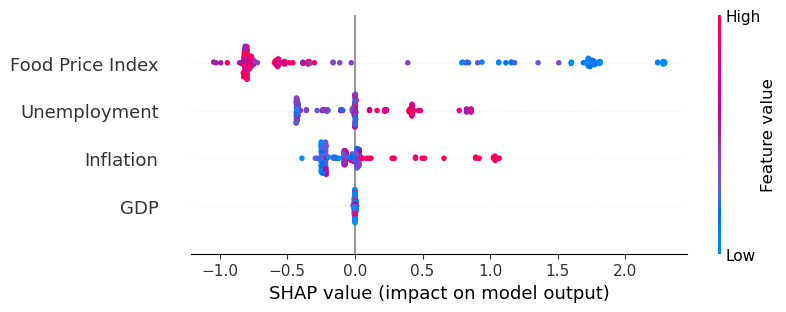

In [191]:
import shap

explainer = shap.Explainer(model, X_train)


# Plot SHAP beeswarm
shap_values = explainer(X_test, check_additivity=False)

shap.plots.beeswarm(shap_values)


In [192]:
#PHASE 9: Save Your Model
import joblib

joblib.dump(model, 'malnutrition_rf_model.pkl')


['malnutrition_rf_model.pkl']

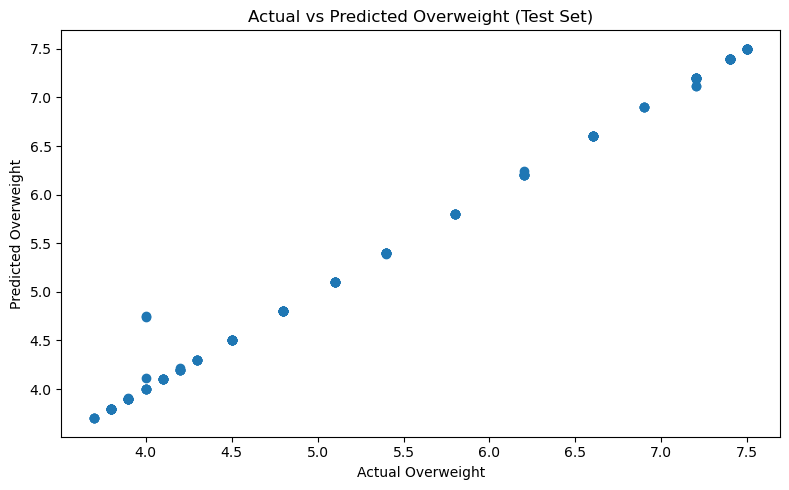

In [193]:
#PHASE 10: Document the Results
#Generate visualizations
# Actual vs Predicted plot
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Overweight")
plt.ylabel("Predicted Overweight")
plt.title("Actual vs Predicted Overweight (Test Set)")
plt.tight_layout()
plt.show()



In [194]:
#Export Cleaned Final Dataset
df.to_csv("final_cleaned_dataset.csv", index=False)


In [195]:
import os
os.getcwd()

'C:\\Users\\Dell\\anaconda_projects\\b9d791bc-3833-4744-993e-986b2dc1c6f0'

In [ ]:
conda env export > environment.yml